# Boston Housing Price Prediction
The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts.

#### Data Exploration

In [1]:
import numpy as np
import torch
import os
from os import path
from sklearn.model_selection import KFold
import pandas as pd
import zipfile
import urllib.request


if not path.exists("UCI"): 
    os.mkdir("UCI")

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
file_name = url.split('/')[-1]
if not path.exists("UCI/" + file_name):
    urllib.request.urlretrieve(url, "UCI/" + file_name)

ds = pd.read_csv('UCI/housing.data', header=0, delimiter="\s+")
ds.describe()

0.00632       18.00       2.310           0      0.5380      6.5750  \
count  505.000000  505.000000  505.000000  505.000000  505.000000  505.000000   
mean     3.620667   11.350495   11.154257    0.069307    0.554728    6.284059   
std      8.608572   23.343704    6.855868    0.254227    0.115990    0.703195   
min      0.009060    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082210    0.000000    5.190000    0.000000    0.449000    5.885000   
50%      0.259150    0.000000    9.690000    0.000000    0.538000    6.208000   
75%      3.678220   12.500000   18.100000    0.000000    0.624000    6.625000   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

            65.20      4.0900           1       296.0       15.30      396.90  \
count  505.000000  505.000000  505.000000  505.000000  505.000000  505.000000   
mean    68.581584    3.794459    9.566337  408.459406   18.461782  356.594376   
std     28.176371    2.107757    8.707553  168.629992    2.162520   91.367787   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.000000    2.100000    4.000000  279.000000   17.400000  375.330000   
50%     77.700000    3.199200    5.000000  330.000000   19.100000  391.430000   
75%     94.100000    5.211900   24.000000  666.000000   20.200000  396.210000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

             4.98       24.00  
count  505.000000  505.000000  
mean    12.668257   22.529901  
std      7.139950    9.205991  
min      1.730000    5.000000  
25%      7.010000   17.000000  
50%     11.380000   21.200000  
75%     16.960000   25.000000  
max     37.970000   50.000000

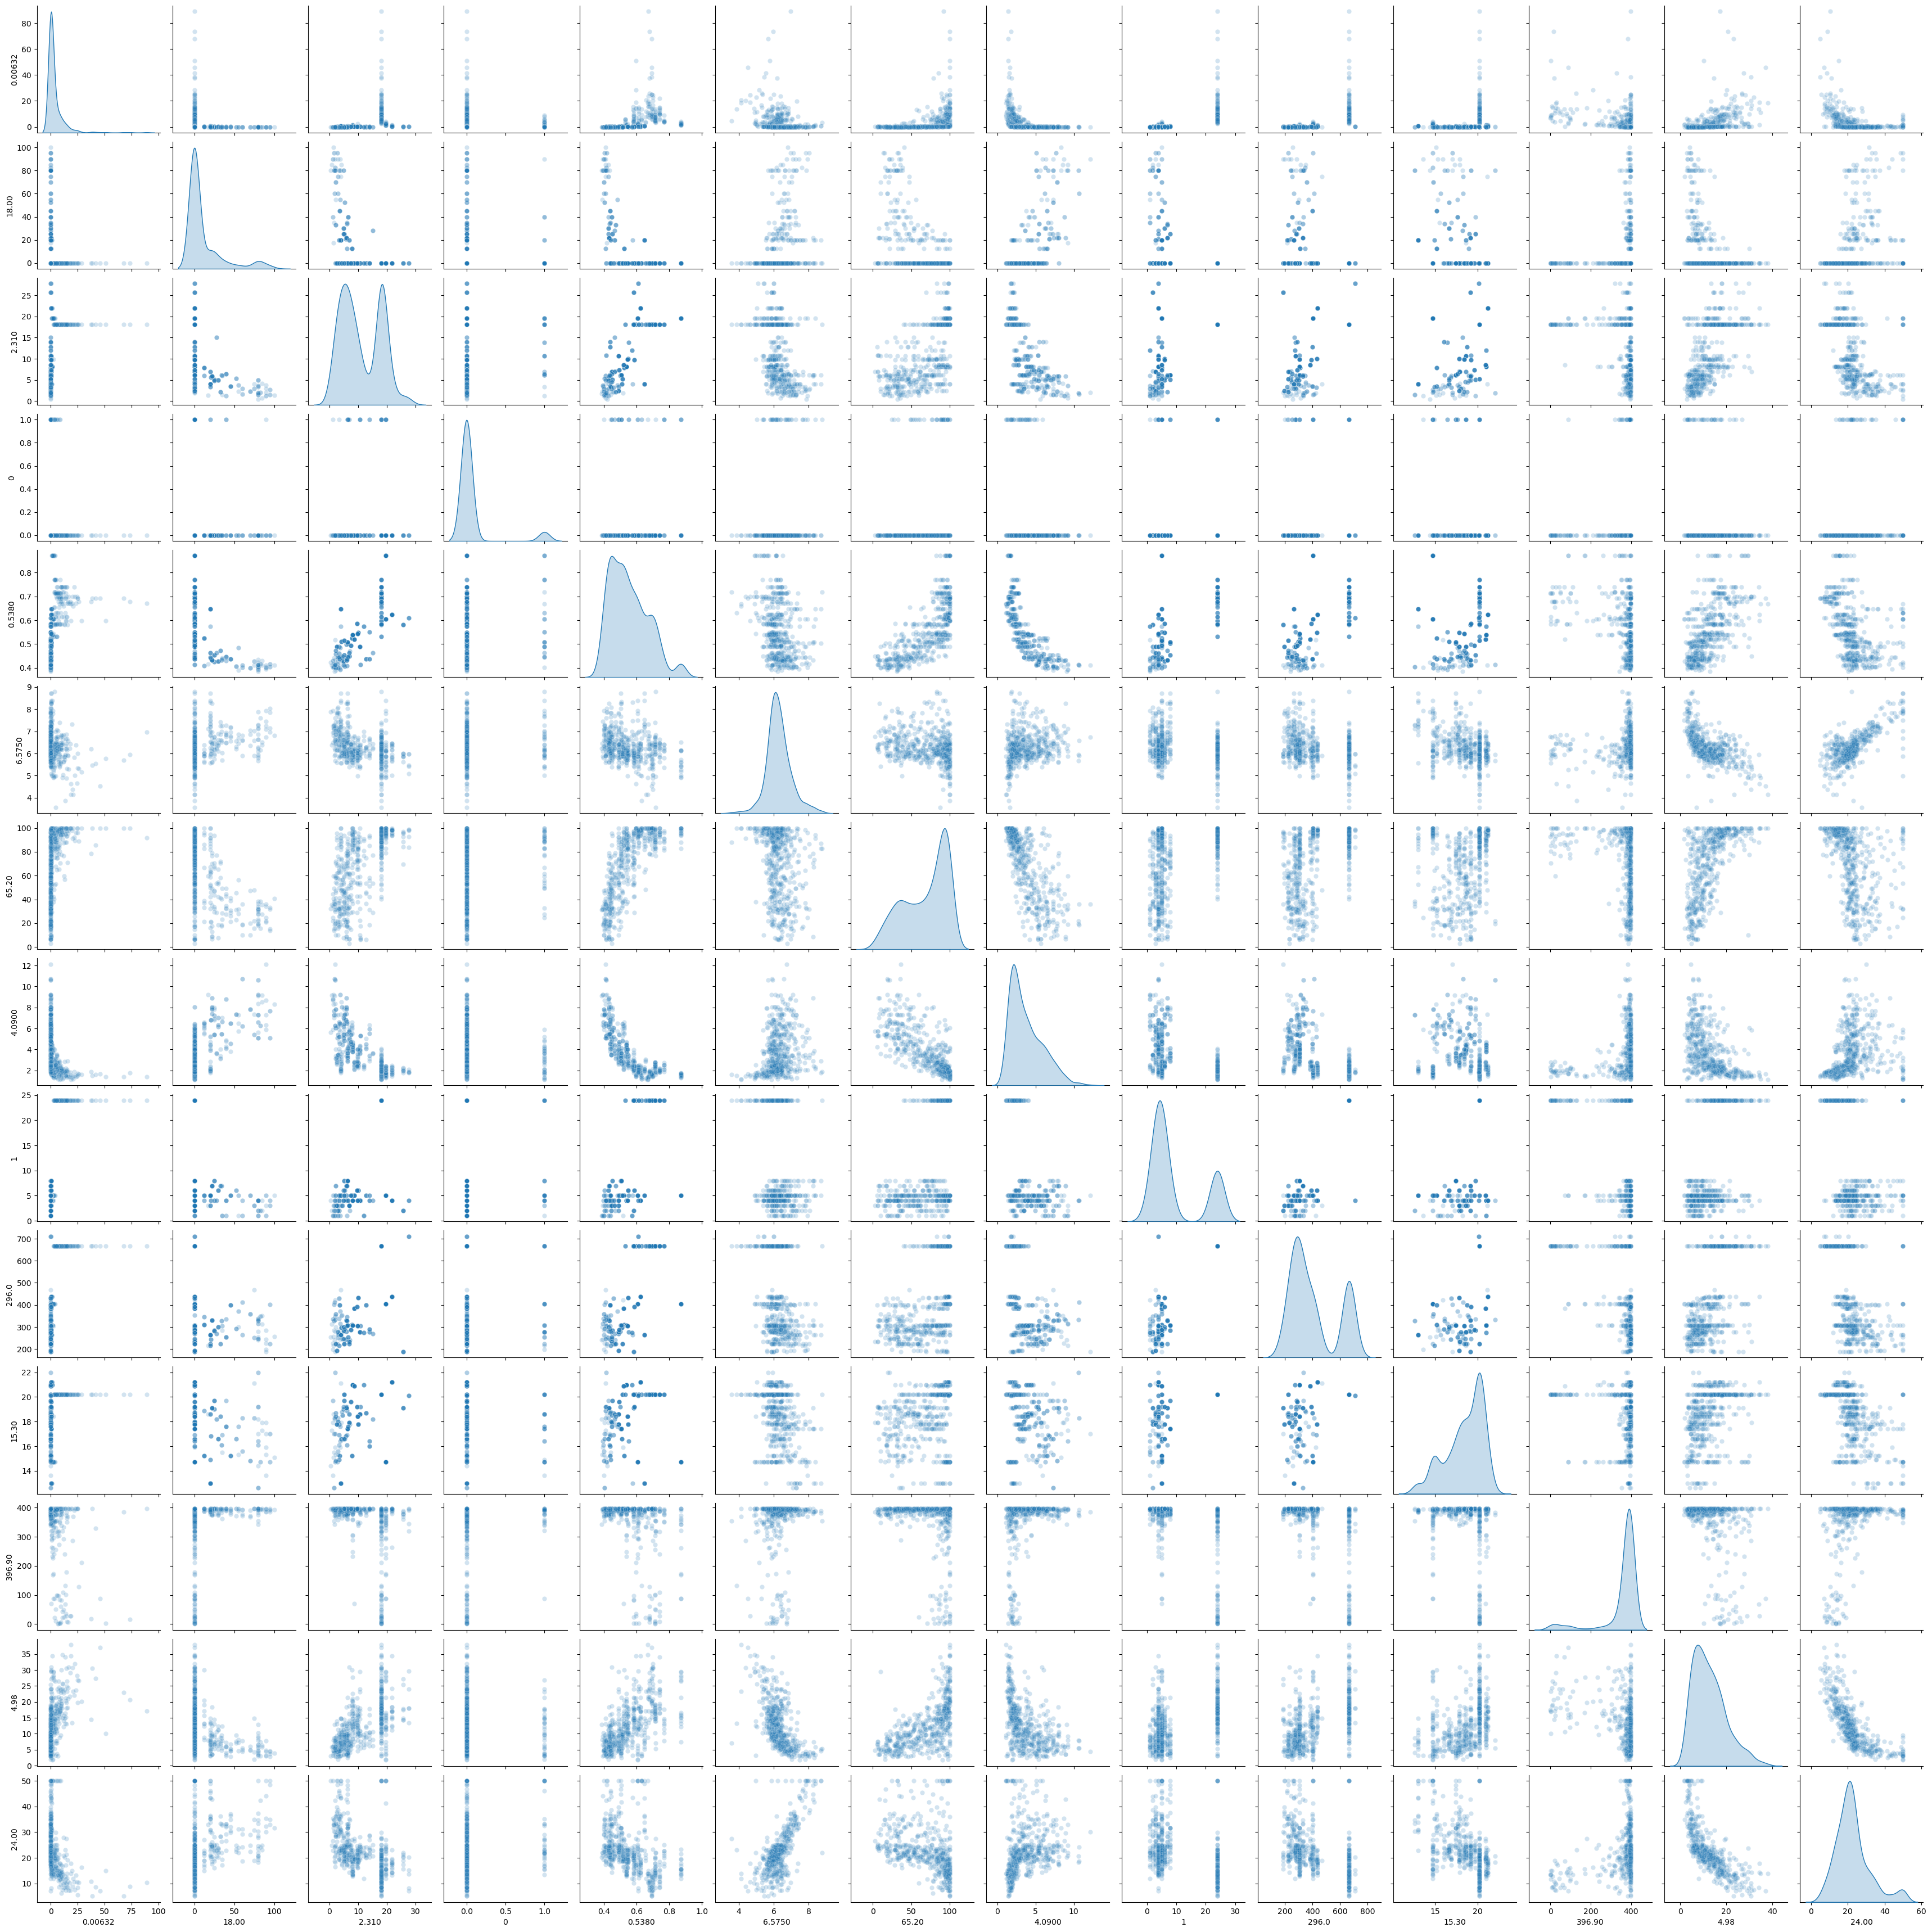

In [2]:
import seaborn as sns

sns.pairplot(ds,diag_kind='kde',plot_kws={'alpha': .2});

In [3]:
# shuffle data
data = ds.values[np.random.permutation(np.arange(len(ds.values)))]

in_dim, out_dim = data.shape[1] - 1, 1

X, y = data[:, :in_dim], data[:, in_dim:]

# normalize and center data
X_means, X_stds = X.mean(axis=0), X.std(axis=0)
y_means, y_stds = y.mean(axis=0), y.std(axis=0)
X = (X - X_means)/X_stds
y = (y - y_means)/y_stds

#### 5 Fold Cross Validation for Linear Regression

In [4]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)
# We use negative mean squared error as score because sklearn expects a score, not a loss
score = cross_val_score(linear_model.LinearRegression(), X, y, cv= kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {-score}')

print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.42428398 0.21724035 0.2964939  0.22513751 0.31222037]
Avg MSE = 0.30


#### 5 Fold Cross Validation for Decision Tree

In [5]:
score = cross_val_score(tree.DecisionTreeRegressor(random_state= 42), X, y, cv=kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.29185184 0.23539981 0.17500529 0.18725884 0.25862982]
Avg MSE = 0.23


#### 5 Fold Cross Validation for Random Forest

In [6]:
score = cross_val_score(ensemble.RandomForestRegressor(random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")

print(f'Scores for each fold: {-score}')
print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

Scores for each fold: [0.15767769 0.09797091 0.11558722 0.11300183 0.17068831]
Avg MSE = 0.13


#### 5 Fold Cross for Hyper param optimization of Decision Tree

In [7]:
max_depth = [1,5,10,20,50,100]

for val in max_depth:
    score = cross_val_score(tree.DecisionTreeRegressor(max_depth= val, random_state= 42), X, y, cv= kf, scoring="neg_mean_squared_error")
    print(f'For max depth: {val}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For max depth: 1
Avg MSE = 0.65
For max depth: 5
Avg MSE = 0.20
For max depth: 10
Avg MSE = 0.22
For max depth: 20
Avg MSE = 0.23
For max depth: 50
Avg MSE = 0.23
For max depth: 100
Avg MSE = 0.23


#### 5 Fold Cross for Hyper param optimization of Random Forest

In [8]:
estimators = [10, 50, 100, 150, 200, 250, 300]

for count in estimators:
    score = cross_val_score(ensemble.RandomForestRegressor(n_estimators= count, random_state= 42), X, y.ravel(), cv= kf, scoring="neg_mean_squared_error")
    print(f'For estimators: {count}')
    print(f'Avg MSE = {"{:.2f}".format(-score.mean())}')

For estimators: 10
Avg MSE = 0.15
For estimators: 50
Avg MSE = 0.14
For estimators: 100
Avg MSE = 0.13
For estimators: 150
Avg MSE = 0.13
For estimators: 200
Avg MSE = 0.13
For estimators: 250
Avg MSE = 0.13
For estimators: 300
Avg MSE = 0.13


#### NN Regressor

In [9]:
from torch import nn

class NNRegressor(nn.Module):
    def __init__(self, layers=[20,30,20], n_features=13, activation=nn.ReLU):
        super().__init__()
        self.layers = []
        self.activation_functions = []

        self.layers.append(nn.Linear(n_features, layers[0]))
        self.activation_functions.append(activation())
        self.add_module(f"layer{0}", self.layers[-1])
        self.add_module(f"act{0}", self.activation_functions[-1])

        for i in range(1, len(layers)):
            self.layers.append(nn.Linear(self.layers[-1].out_features, layers[i]))
            self.activation_functions.append(activation())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.activation_functions[-1])

        self.output = nn.Linear(self.layers[-1].out_features, 1)

    def forward(self, x):
        for layer, act in zip(self.layers, self.activation_functions):
            x=act(layer(x))

        x = self.output(x)
        return x

#### Grid search hyper param optimization for NN

In [10]:
from sklearn.model_selection import GridSearchCV
from torch import optim
from skorch import NeuralNetRegressor

param_grid = {
    'optimizer': [optim.Adam, optim.Adamax, optim.NAdam],
    'module__activation': [nn.Identity, nn.ReLU, nn.GELU, nn.Tanh, nn.Sigmoid],
    'batch_size': [10, 25, 50],
    'module__layers': [[10,20,10],[30,20,10],[30,30,30]],
    'lr': [0.0001, 0.001, 0.01],
}

grid = GridSearchCV(
    estimator = NeuralNetRegressor(module=NNRegressor),
    param_grid = param_grid,
    n_jobs = -1,
    cv = 3,
    error_score = 'raise',
    return_train_score = True,
    verbose = 0,
    scoring = 'neg_mean_squared_error'
)

In [11]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

grid.fit(X_tensor, y_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9273        1.1381  0.0349
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0518        1.0239  0.0297
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.7805        1.5029  0.0343
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9469        1.1112  0.0349
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8138        1.1120  0.0322
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.3196        1.0984  0.0362
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0871        1.1203  0.0349
      2        0.8787        1.0967  0.0120
      2        0.8805        1.0

GridSearchCV(cv=3, error_score='raise',
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.NNRegressor'>,
),
             n_jobs=-1,
             param_grid={'batch_size': [10, 25, 50],
                         'lr': [0.0001, 0.001, 0.01],
                         'module__activation': [<class 'torch.nn.modules.linear.Identity'>,
                                                <class 'torch.nn.modules.activation.ReLU'>,
                                                <class 'torch.nn.modules.activation.GELU'>,
                                                <class 'torch.nn.modules.activation.Tanh'>,
                                                <class 'torch.nn.modules.activation.Sigmoid'>],
                         'module__layers': [[10, 20, 10], [30, 20, 10],
                                            [30, 30, 30]],
                         'optimizer': [<class 'torch.optim.adam.Adam'>,
                                       <class 'torch.optim.adamax.Adamax'>,
                                       <class 'torch.optim.nadam.NAdam'>]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [12]:
print("Best params:")
grid.best_params_

Best params:


{'batch_size': 25,
 'lr': 0.01,
 'module__activation': torch.nn.modules.activation.GELU,
 'module__layers': [30, 20, 10],
 'optimizer': torch.optim.adam.Adam}

In [13]:
print(f'Best MSE = {"{:.2f}".format(-grid.best_score_)}')

Best MSE = 0.15


# Results
The best model is the Random Forest with at least 50 estimators. The avarage MSE for the model is 0.13